In [31]:
"Les différentes instances"

def choice_instance(instance):
    
    global INSTANCE_NAME
    global NBR_MACHINES
    global NBR_WORKERS
    global QUALIFICATIONS

    if instance == "INSTANCE_1":
        INSTANCE_NAME = "Instance 1"
        NBR_MACHINES = 8
        NBR_WORKERS = 4
        QUALIFICATIONS = [[True, True, False, False, False, False, False, False], \
                          [False, False, True, True, False, False, False, False], \
                          [False, False, False, False, True, True, False, False], \
                          [False, False, False, False, False, False, True, True]]

    if instance == "INSTANCE_2":
        INSTANCE_NAME = "Instance 2"
        NBR_MACHINES = 8
        NBR_WORKERS = 4
        QUALIFICATIONS = [[True, False, True, False, False, True, False, False], \
                          [False, True, False, False, True, False, True, True], \
                          [False, True, False, True, True, False, False, True], \
                          [True, False, True, True, False, True, True, False]]

    if instance == "INSTANCE_3":
        INSTANCE_NAME = "Instance 3"
        NBR_MACHINES = 8
        NBR_WORKERS = 6
        QUALIFICATIONS = [[True, True, False, False, False, False, False, False], \
                          [False, False, True, False, False, False, False, False], \
                          [False, False, False, True, False, True, False, False], \
                          [False, False, False, False, True, False, False, True], \
                          [False, False, True, False, False, True, False, False], \
                          [True, False, False, False, False, False, True, False]]

    if instance == "INSTANCE_4":
        INSTANCE_NAME = "Instance 4"
        NBR_MACHINES = 8
        NBR_WORKERS = 6
        QUALIFICATIONS = [[True, True, True, False, False, False, False, False], \
                          [False, False, False, True, True, True, False, False], \
                          [True, False, True, False, False, True, True, True], \
                          [False, False, True, False, True, False, True, True], \
                          [False, True, False, False, False, True, True, False], \
                          [True, False, False, True, False, False, True, True]]

In [32]:
"Paramètres communs à toutes les instances"

NBR_PRODUCT_TYPES = 4
LAMBDAS = [0.29, 0.32, 0.47, 0.38]
ROUTES = [[0, 1, 2, 3, 7], [1, 3, 6], [2, 4, 0], [4, 5, 6, 7]]

LOWER_PT = [[0.58, 0.23, 0.81, 0.12, 0, 0, 0, 0.82], [0, 0.59, 0, 0.74, 0, 0, 0.30, 0], \
            [0.57, 0, 0.37, 0, 0.35, 0, 0, 0], 
            [0, 0, 0, 0, 0.36, 0.61, 0.78, 0.18]] #[i][j] temps min mis par le type i sur la machine j
            
UPPER_PT = [[0.78, 0.56, 0.93, 0.39, 0, 0, 0, 1.04], [0, 0.68, 0, 0.77, 0, 0, 0.55, 0], \
            [0.64, 0, 0.54, 0, 0.63, 0, 0, 0], 
           [0, 0, 0, 0, 0.51, 0.7, 0.85, 0.37]] #[i][j] temps max mis par le type i sur la machine j

TIME_LIMIT = 1000000 #permet la terminaison de la simulation même si le système n'est pas stable

In [33]:
import random

def interarrival_time(lambd):
    return random.expovariate(lambd)

In [34]:
import heapq

class System(object):
    
    def __init__(self):
        self.schedule = []
        self.machines = []
        for i in range(NBR_MACHINES):
            machine = Machine(i)
            self.machines.append(machine)
        self.workers = []
        self.waiting = []
        for i in range(NBR_WORKERS):
            worker = Worker(i)
            self.workers.append(worker)
            self.waiting.append(worker)
        self.products = [] #contient la liste des produits traités
        self.treated_per_type = [] #compte le nombre de produits traités par type
        for i in range(NBR_PRODUCT_TYPES):
            self.treated_per_type.append(0)

################################################################################################################
################################################################################################################ 
            
#La méthode suivante teste s'il y a un employé qualifié pour la machine ; si oui, le place dans l'espace "worker"        
#de la machine

#C'est éventuellement sur cette méthode qu'il faut travailler pour l'équilibrage de charge
    def worker_available(self, machine):
        qualified_worker = []
        for i in range(len(self.waiting)):
            if self.waiting[i].qualifications[machine.id]:
                qualified_worker.append(i)
            
        utilisation={}
        for j in qualified_worker:
            utilisation[j]= self.waiting[j].worked_time

        if qualified_worker != []:
            best_worker = min(utilisation, key=utilisation.get) 
            worker = self.waiting.pop(best_worker)
            machine.worker.append(worker)
            return True
        else:
            return False
#Les différents événements       
    
class Event(object):
    
    def __init__(self, time):
        self.time = time
        self.type = ""
    
    #On redéfinit la comparaison pour des événements ; nécessaire pour heap en cas d'égalité d'instant de
    #réalisation. Renvoie toujours True ; fait donc une comparaison arbitraire.
    
    def __lt__(self, other):
        return True
        
class Event_arrival(Event):
    
    def __init__(self, time, i, type_product):
        self.time = time
        self.id = i
        self.type_product = type_product
        self.type = "arrival"
            
    def action(self, sys):
        
        #print("Le produit numéro %d, de type %d, arrive dans l'atelier" % (self.id, self.type_product))
        
        e_next_arrival = Event_arrival(self.time + interarrival_time(LAMBDAS[self.type_product]), \
                                       self.id + 1, self.type_product)
        heapq.heappush(sys.schedule, (e_next_arrival.time, e_next_arrival))
        product = Product(self.id, self.type_product, self.time)
        product.route(sys, self.time)
              
class Event_end_service(Event):
    
    def __init__(self, time, machine):
        self.time = time
        self.machine = machine
        self.type = "end_service"
        
    def action(self, sys):
        
        #print("L'employé %d finit de travailler sur la machine %d" % \
        #   (self.machine.worker[0].id, self.machine.id))
        
        self.machine.worker[0].worked_time +=(self.time-self.machine.worker[0].start_times[-1]) 
 
        self.machine.worker[0].end_times.append(self.time)     
        
        #Le produit reprend sa route dans l'atelier
    
        product = self.machine.service.pop(0)
        product.current_step += 1
        product.route(sys, self.time)
        
        #Met dans l'espace de service le prochain produit dans l'espace d'attente
        
        if len(self.machine.queue):
            next_product = self.machine.queue.pop(0)
            self.machine.service.append(next_product)
            self.machine.awaiting = True
        else:
            self.machine.available = True
            
        #L'employé libéré cherche une prochaine tâche
        worker = self.machine.worker.pop(0)
        worker.algo(sys, self.time)
        
        #S'il y a un nouveau produit dans l'espace de service, mais qu'aucun employé n'est là pour s'en occuper,
        #on cherche un employé disponible dans la salle d'attente
        
        if self.machine.awaiting:
            if sys.worker_available(self.machine):
                    
                    #print("L'employé %d se met à travailler sur la machine %d" %\
                    #      (self.machine.worker[0].id, self.machine.id))
                    
                self.machine.awaiting = False    
                self.machine.worker[0].start_times.append(self.time)
                e_end_service = Event_end_service(self.time + \
                                    next_product.processing_times[ROUTES[next_product.type][next_product.current_step]], \
                                    self.machine)
                heapq.heappush(sys.schedule, (e_end_service.time, e_end_service))

        
class Event_ultimate_end_simulation(Event):
    
    def __init__(self, time):
        self.time = time
        self.type = "ultimate_end"

In [35]:
class Product(object):
    
    def __init__(self, i, type_product, time):
        self.id = i
        self.type = type_product
        self.current_step = 0 #étape du produit dans l'atelier; attention, ce n'est pas le numéro de la machine courante
        self.processing_times = []
        for j in range(NBR_MACHINES):
            self.processing_times.append( \
            random.uniform(LOWER_PT[type_product][j], UPPER_PT[type_product][j]))
        self.arrival_time = time
        self.departure_time = 0

#La méthode suivante détermine la machine suivante que le produit courant doit visiter, 
#et suppose que current_step a déjà été mis à jour. S'il n'y a plus de machine à visiter, 
#le produit quitte le système.

    def route(self, sys, time):
        if self.current_step < len(ROUTES[self.type]):
            machine = sys.machines[ROUTES[self.type][self.current_step]]
            if machine.available:
                machine.service.append(self)
                machine.available = False
                if sys.worker_available(machine):
                    
                    #print("L'employé %d se met à travailler sur la machine %d" %\
                    #      (machine.worker[0].id, machine.id))
                    machine.awaiting = False
                    machine.worker[0].start_times.append(time)
                    e_end_service = Event_end_service(time + \
                                                  self.processing_times[ROUTES[self.type][self.current_step]], \
                                                     machine)
                    heapq.heappush(sys.schedule, (e_end_service.time, e_end_service))
                else:
                    machine.awaiting = True
            else:
                sys.machines[ROUTES[self.type][self.current_step]].queue.append(self)
        else:
            
            #print("Le produit numéro %d, de type %d, quitte l'atelier" % (self.id, self.type))
            
            self.departure_time = time
            sys.products.append(self)
            sys.treated_per_type[self.type] += 1
            
            
class Worker(object):
    
    def __init__(self, i):
        self.id = i
        self.qualifications = QUALIFICATIONS[i]
        self.start_times = []
        self.end_times = []
        self.worked_time = 0

################################################################################################################
################################################################################################################
  
#C'est sur cette méthode qu'il faut travailler    

    def algo(self, sys, time):
        best_machine = -1 
        
#Plus précisément, c'est juste après que tout se joue
        
        if METHOD == "FIRST":
            i = 0
            while (best_machine == -1) and (i < NBR_MACHINES):
        
#Un employé (self) peut être affecté à une machine i si et seulement si un
#produit est en attente de service, et l'employé est qualifié. C'est le test suivant.

                if sys.machines[i].awaiting and self.qualifications[i]:
                    best_machine = i
                i += 1
## my code
        import numpy as np
        if METHOD == "WINQ":
            candidate_machines={} 
            i = 0
            while (i < NBR_MACHINES):
                if sys.machines[i].awaiting and self.qualifications[i]:
                    candidate_machines[i]=0
                i += 1

            for i in candidate_machines:
                #retrieves the awaiting product of the candidate machine
                product = sys.machines[i].service[0]
                #finds in which part of the rout the product is
                current_machine = ROUTES[product.type][product.current_step]
                remaining_time = np.sum(product.processing_times[current_machine:])
                candidate_machines[i] = remaining_time
            
            if candidate_machines != {}:
                best_machine = min(candidate_machines, key=candidate_machines.get)



            
#Plus précisément, c'est juste avant que tout se joue
                        
        if (best_machine != -1):
            machine = sys.machines[best_machine]
            machine.worker.append(self)
            machine.awaiting = False
                
            #print("L'employé %d se met à travailler sur la machine %d" % (self.id, machine.id))
            
            self.start_times.append(time)
            e_end_service = Event_end_service(time + \
                                    machine.service[0].processing_times[best_machine], machine)
            heapq.heappush(sys.schedule, (e_end_service.time, e_end_service))
        else:
                
            #print("L'employé %d se met à attendre" % self.id)
                
            sys.waiting.append(self)
        
            
################################################################################################################
################################################################################################################

class Machine(object):
    
    def __init__(self, i):
        self.id = i
        self.queue = []
        self.service = []
        self.worker = []
        self.awaiting = False #vrai s'il y a un produit dans l'espace de service attendant un employé
        self.available = True #vrai si l'espace de service est libre

In [37]:
"Simule et renvoie la valeur de certains critères"

import random
from statistics import mean
from scipy.stats import t, sem

for x in range(4):
    INSTANCE = "INSTANCE_"+str(x+1)
    
    METHOD = "WINQ"
    NBR_RUNS = 20
    NBR_PRODUCTS_TRANS = 20000
    NBR_PRODUCTS_TOTAL = 40000
    CONFIDENCE_LEVEL = 95

    INSTANCE_NAME = ""
    NBR_MACHINES = 0
    NBR_WORKERS = 0
    QUALIFICATIONS = []

    choice_instance(INSTANCE)

    print(INSTANCE_NAME)
    print("Méthode : ", end="") ; print(METHOD)

    #calcul la proportion espérée de produit par type (utile pour tester la stabilité du système)
    proportions = []
    total = 0
    for i in range(NBR_PRODUCT_TYPES):
        total += LAMBDAS[i]
    for i in range(NBR_PRODUCT_TYPES):
        proportions.append(LAMBDAS[i] / total)

    #Simulation

    average_sojourn_times = []
    average_utilization = [] #temps moyen d'"utilisation" des employés, par employé

    for j in range(NBR_WORKERS): #utilisé pour les statistiques
        average_utilization.append([])

    for i in range(NBR_RUNS):
        random.seed(i) #permet de la reproductibilité
        sys = System()
        e_fin = Event_ultimate_end_simulation(TIME_LIMIT)
        heapq.heappush(sys.schedule, (e_fin.time, e_fin))
        for j in range(NBR_PRODUCT_TYPES):
            e_debut = Event_arrival(interarrival_time(LAMBDAS[j]), 0, j)
            heapq.heappush(sys.schedule, (e_debut.time, e_debut))
        
        #boucle de simulation
        not_all_treated = True
        while sys.schedule[0][1].type != "ultimate_end" and not_all_treated:
            (time, e) = heapq.heappop(sys.schedule)
            e.action(sys)
            test = False
            for j in range(NBR_PRODUCT_TYPES):
                test = test or (sys.treated_per_type[j] < NBR_PRODUCTS_TOTAL * proportions[j])
            not_all_treated = not_all_treated and test
            
        if sys.schedule[0][1].type == "ultimate_end":
            print("ATTENTION : la simulation n'a pas permis de traiter tous les produits.")
        
    #Calcule du temps de séjour moyen pour la réplication courante

        sojourn_times = []

        if not_all_treated:
            print("Sur la réplication %d, il n'y a pas eu le nombre de produits traités attendus" % i)     
        else:
            start_perm = sys.products[NBR_PRODUCTS_TRANS].arrival_time
            end_perm = 0
            for j in range(NBR_PRODUCTS_TRANS, NBR_PRODUCTS_TOTAL):
                
                #Détermine les temps moyens
                sojourn_times.append(sys.products[j].departure_time - sys.products[j].arrival_time)
                
                #Détermine la durée du régime permanent analysé
                if sys.products[j].arrival_time < start_perm:
                    start_perm = sys.products[j].arrival_time
                if sys.products[j].departure_time > end_perm:
                    end_perm = sys.products[j].departure_time
            duration = end_perm - start_perm
            average_sojourn_times.append(mean(sojourn_times))
                
            #Détermine l'"utilisation" de chaque employé
            for j in range(NBR_WORKERS):
                total_active_time = 0
                for k in range(len(sys.workers[j].start_times)):
                    if (sys.workers[j].start_times[k] >= start_perm) and (k < len(sys.workers[j].end_times)):
                        if (sys.workers[j].end_times[k] <= end_perm):
                            total_active_time += sys.workers[j].end_times[k] - sys.workers[j].start_times[k]
                
                average_utilization[j].append(total_active_time / duration)


    average_sojourn_times_mean = mean(average_sojourn_times)
    average_sojourn_times_standard_error = sem(average_sojourn_times)
    confidence_interval = t.interval(CONFIDENCE_LEVEL / 100, len(average_sojourn_times) - 1, \
                                    average_sojourn_times_mean, average_sojourn_times_standard_error)

    print("Temps de séjour moyen d'un produit dans l'atelier " \
            "(sur les %d derniers produits à quitter l'atelier) : "\
            "%.4f" % (NBR_PRODUCTS_TOTAL - NBR_PRODUCTS_TRANS, average_sojourn_times_mean))
    print("Intervalle de confiance à %d%%: " % CONFIDENCE_LEVEL, end="") ; print("(%.4f, %.4f)" \
                                                                                % confidence_interval)

    print("Utilisation moyenne de l'employé")
    for j in range(NBR_WORKERS):
        print("%d : %.4f" % (j, mean(average_utilization[j])))

Instance 1
Méthode : WINQ
Temps de séjour moyen d'un produit dans l'atelier (sur les 20000 derniers produits à quitter l'atelier) : 5.3283
Intervalle de confiance à 95%: (5.2725, 5.3840)
Utilisation moyenne de l'employé
0 : 0.7996
1 : 0.7818
2 : 0.6452
3 : 0.8199
Instance 2
Méthode : WINQ


KeyboardInterrupt: 

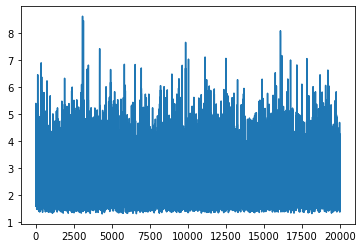

In [84]:
"Tracé des temps de séjour sur la dernière réplication"

import matplotlib.pyplot as plt

plt.plot(sojourn_times)
plt.show()

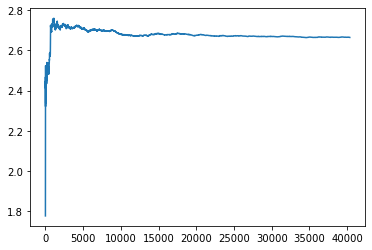

In [85]:
"Tracé du temps moyen de séjour depuis le début, pour chaque produit, pour la dernière réplication"

cumulated_sojourn_time = 0
average_sojourn_time_last_run = []
data = []

for j in range(len(sys.products)):
    data.append((sys.products[j].arrival_time, sys.products[j].departure_time - sys.products[j].arrival_time))

sorted(data, key = lambda entry: entry[0])

for j in range(len(sys.products)):
    cumulated_sojourn_time += data[j][1]
    average_sojourn_time_last_run.append(cumulated_sojourn_time / (j+1))
    
plt.plot(average_sojourn_time_last_run)
plt.show()

In [65]:
import numpy as np
b=np.array([0,1,2])
a=np.array([1,2,3])

sum(a-b)

3